In [55]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as stattools
import statsmodels.tsa.seasonal as seasonal
import statsmodels.graphics.tsaplots as tsaplots
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
ibm_df = pd.read_csv('datasets/ibm-common-stock-closing-prices.csv')
ibm_df.head()

,Date,IBM common stock closing prices
0,1962-01-02,572.00
1,1962-01-03,577.00
2,1962-01-04,571.25
3,1962-01-05,560.00
4,1962-01-08,549.50


In [3]:
ibm_df.rename(columns={'IBM common stock closing prices': 'Close_Price'},inplace=True)

In [4]:
# Function for Single exponential smoothing
def single_exp_smoothing(x, alpha):
    F = [x[0]] # first value is same as series
    for t in range(1, len(x)):
        F.append(alpha * x[t] + (1 - alpha) * F[t-1])
    return F

In [15]:
# Single exponential smoothing forecasting
ibm_df['SES0'] = single_exp_smoothing(ibm_df['Close_Price'], 0)
ibm_df['SES1'] = single_exp_smoothing(ibm_df['Close_Price'], 1)
ibm_df['SES'] = single_exp_smoothing(ibm_df['Close_Price'], 0.4)

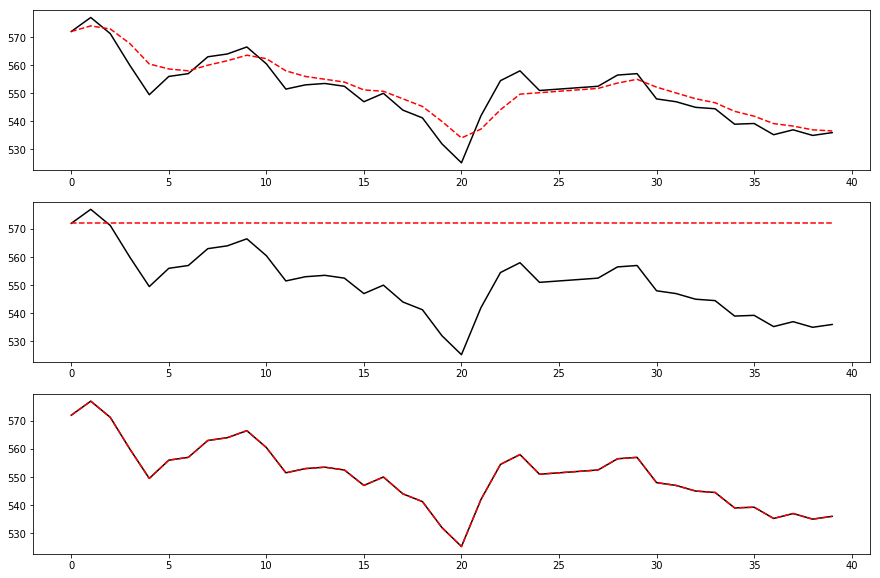

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(311)
ibm_df['Close_Price'][:40].plot(style='k')
ibm_df['SES'][:40].plot(style='r--')
plt.subplot(312)
ibm_df['Close_Price'][:40].plot(style='k')
ibm_df['SES0'][:40].plot(style='r--')
plt.subplot(313)
ibm_df['Close_Price'][:40].plot(style='k')
ibm_df['SES1'][:40].plot(style='r--')

In [27]:
#Read dataset into a pandas.DataFrame
beer_df = pd.read_csv('datasets/quarterly-beer-production-in-aus-March 1956-June 1994.csv')
beer_df.rename(columns={'Quarterly beer production in Australia: megalitres. March 1956 ? June 1994':'Beer_Prod'},
              inplace=True)

In [28]:
# Function for double exponential smoothing
def double_exp_smoothing(x, alpha, beta):
    yhat = [x[0]] # first value is same as series
    for t in range(1, len(x)):
        if t==1:
            F, T= x[0], x[1] - x[0]
        F_n_1, F = F, alpha*x[t] + (1-alpha)*(F+T)
        T=beta*(F-F_n_1)+(1-beta)*T
        yhat.append(F+T)
    return yhat


In [29]:
beer_df['DEF00'] = double_exp_smoothing(beer_df['Beer_Prod'],0, 0)
beer_df['DEF01'] = double_exp_smoothing(beer_df['Beer_Prod'],0, 1)
beer_df['DEF10'] = double_exp_smoothing(beer_df['Beer_Prod'],1, 0)
beer_df['DEF11'] = double_exp_smoothing(beer_df['Beer_Prod'],1, 1)

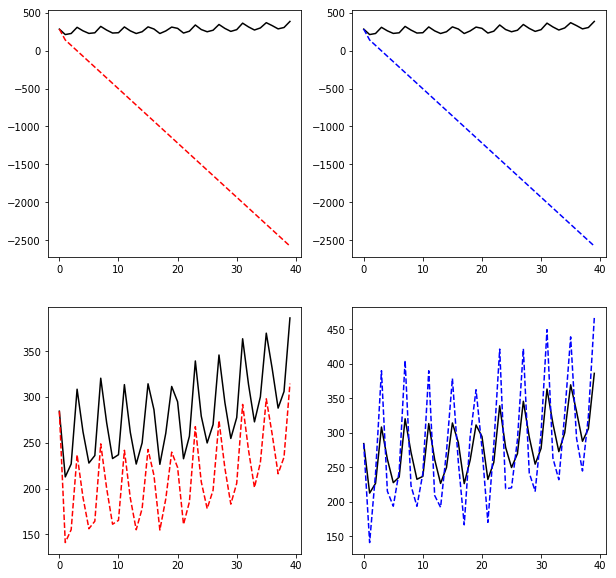

In [31]:
plt.figure(figsize=(10,10))
plt.subplot(221)
beer_df['Beer_Prod'][:40].plot(style='k')
beer_df['DEF00'][:40].plot(style='r--')
plt.subplot(222)
beer_df['Beer_Prod'][:40].plot(style='k')
beer_df['DEF01'][:40].plot(style='b--')
plt.subplot(223)
beer_df['Beer_Prod'][:40].plot(style='k')
beer_df['DEF10'][:40].plot(style='r--')
plt.subplot(224)
beer_df['Beer_Prod'][:40].plot(style='k')
beer_df['DEF11'][:40].plot(style='b--')

In [32]:
beer_df['DEF'] = double_exp_smoothing(beer_df['Beer_Prod'], 0.4, 0.7)

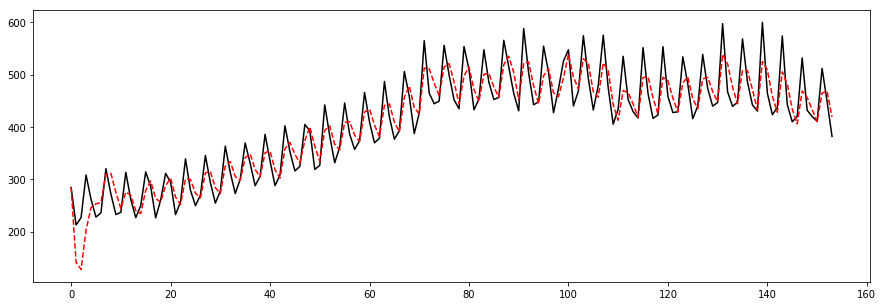

In [36]:
plt.figure(figsize=(15,5))
plt.subplot(111)
beer_df['Beer_Prod'].plot(style='k')
beer_df['DEF'].plot(style='r--')

In [42]:
#read the data from into a pandas.DataFrame
wisc_emp = pd.read_csv('datasets/wisconsin-employment-time-series.csv')

In [43]:
# Initialize trend value
def initialize_T(x, seasonLength):
    total=0.0
    for i in range(seasonLength):
        total+=float(x[i+seasonLength]-x[i])/seasonLength
    return total

In [44]:
# Initialize seasonal trend
def initialize_seasonalilty(x, seasonLength):
    seasons={}
    seasonsMean=[]
    num_season=int(len(x)/seasonLength)
    # Compute season average
    for i in range(num_season):
        seasonsMean.append(sum(x[seasonLength*i:seasonLength*i+seasonLength])/float(seasonLength))
    # compute season intial values
    for i in range(seasonLength):
        tot=0.0
        for j in range(num_season):
            tot+=x[seasonLength*j+i]-seasonsMean[j]
        seasons[i]=tot/num_season
    return seasons

In [51]:
# Triple Exponential Smoothing Forecast
def triple_exp_smoothing(x, seasonLength, alpha, beta, gamma, h):
    yhat=[]
    S = initialize_seasonalilty(x, seasonLength)
    for i in range(len(x)+h):
        if i == 0:
            F = x[0]
            T = initialize_T(x, seasonLength)
            yhat.append(x[0])
            continue
        if i >= len(x):
            m = i - len(x) + 1
            yhat.append((F + m*T) + S[i%seasonLength])
        else:
            obsval = x[i]
            F_last, F= F, alpha*(obsval-S[i%seasonLength]) + (1-alpha)*(F+T)
            T = beta * (F-F_last) + (1-beta)*T
            S[i%seasonLength] = gamma*(obsval-F) + (1-gamma)*S[i%seasonLength]
            yhat.append(F+T+S[i%seasonLength])
    return yhat


In [52]:
wisc_emp['TEF001'] = triple_exp_smoothing(wisc_emp['Employment'], 12, 0, 0, 1, 0)
wisc_emp['TEF010'] = triple_exp_smoothing(wisc_emp['Employment'], 12, 0, 1, 0, 0)
wisc_emp['TEF100'] = triple_exp_smoothing(wisc_emp['Employment'], 12, 1, 0, 0, 0)

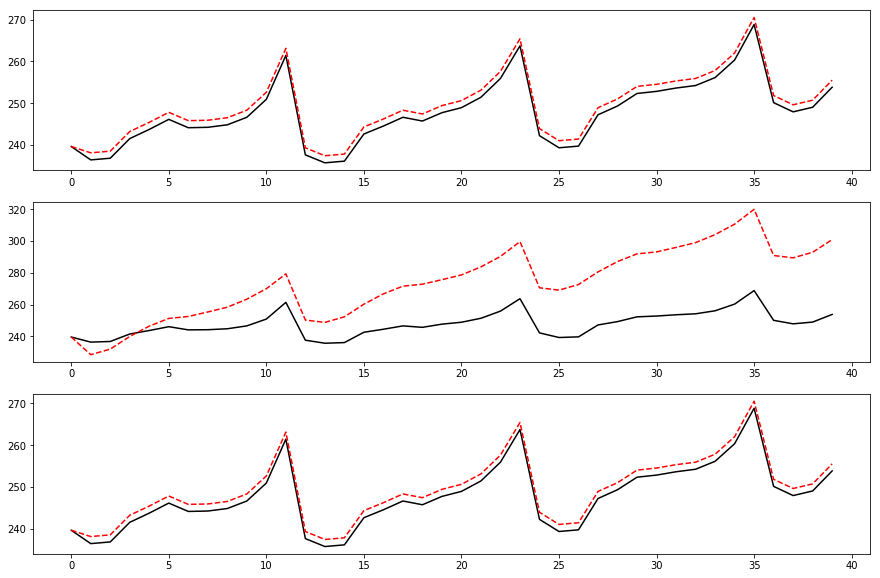

In [53]:
plt.figure(figsize=(15,10))
plt.subplot(311)
wisc_emp['Employment'][:40].plot(style='k')
wisc_emp['TEF001'][:40].plot(style='r--')
plt.subplot(312)
wisc_emp['Employment'][:40].plot(style='k')
wisc_emp['TEF010'][:40].plot(style='r--')
plt.subplot(313)
wisc_emp['Employment'][:40].plot(style='k')
wisc_emp['TEF100'][:40].plot(style='r--')

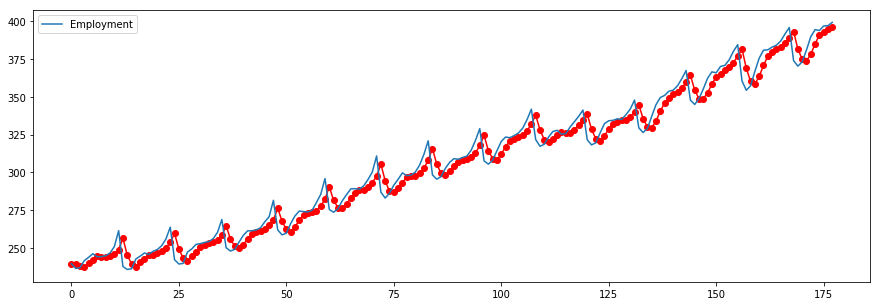

In [69]:
emp_df = pd.DataFrame(data=wisc_emp['Employment'])
fit1 = SimpleExpSmoothing(emp_df).fit(smoothing_level=0.6,optimized=False)
plt.figure(figsize=(15,5))
plt.subplot(111)
ax = fit1.fittedvalues.plot(marker='o', color='red')
emp_df.plot(ax=ax)

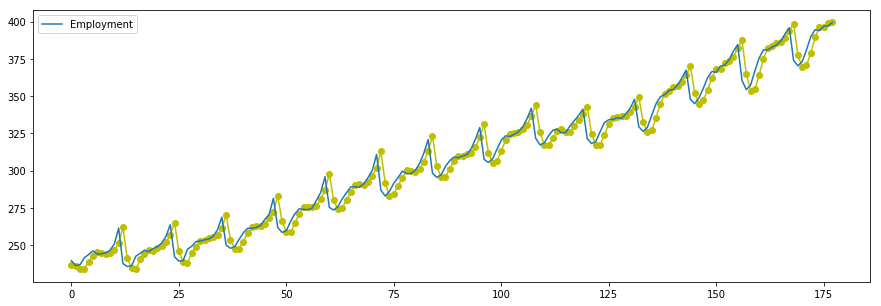

In [77]:
fit2 = Holt(emp_df, exponential=False).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
plt.figure(figsize=(15,5))
plt.subplot(111)
ax = fit2.fittedvalues.plot(marker='o', color='y')
emp_df.plot(ax=ax)

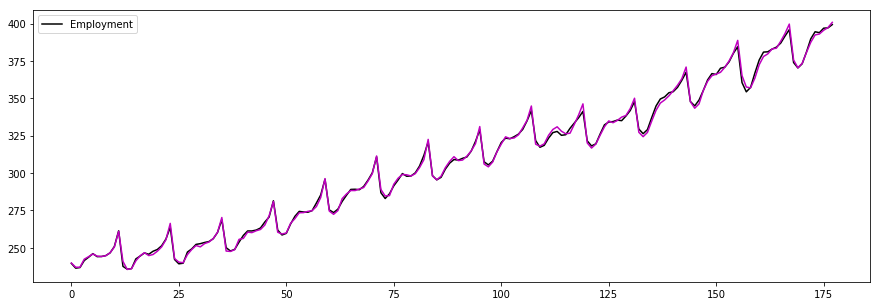

In [90]:
fit3 = ExponentialSmoothing(emp_df, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)
plt.figure(figsize=(15,5))
ax = plt.subplot(111)
emp_df.plot(style='k', ax=ax)
fit3.fittedvalues.plot(ax=ax, color='m')


In [92]:
fcast = fit3.forecast(10)
fcast

178    405.837694
179    413.106922
180    391.665166
181    388.170689
182    391.493507
183    399.705448
184    407.324475
185    410.692591
186    409.401851
187    411.444986
dtype: float64

In [93]:
fit3.params

{'smoothing_level': 0.7368421052631579,
 'smoothing_slope': 0.052583924509632,
 'smoothing_seasonal': 0.2631578947368421,
 'damping_slope': nan,
 'initial_level': 7.072926129707527,
 'initial_slope': 0.0017771725087143014,
 'initial_seasons': array([-0.30981783, -0.32825531, -0.32688451, -0.29352485, -0.28034281,
        -0.26860872, -0.27972655, -0.28084228, -0.27888385, -0.26810305,
        -0.24561519, -0.18628244]),
 'use_boxcox': True,
 'lamda': 0.0743582165299195,
 'remove_bias': False}